# Denoising the MNIST database using an autoencoder

This notebook will guide you trough the use of a convolutional autoencoder in the task of denoising. The main objective is to use an autoencoder to find reduced representation of the images in the MNIST databas, and then to use the generated model to remove different amounts of synthetic noise applied to the database.

# Student: Romain Claret

### Train yourself first
Before starting, go to the following link and learn how autoencoders are built using Keras:

https://blog.keras.io/building-autoencoders-in-keras.html

Then:

<div class="alert alert-block alert-info">
<ul>
    <li>Build your own autoencoder following the recommendations given in the tutorial. We have tested the following architecture (it is simpler than the one proposed in the tuorial):</li>
</ul>
  
  <table>
    <tr> <td><b>Layer (type)</b></td> <td><b>Output Shape</b></td> <td><b>N. Params</b></td></tr>
    <tr> <td>input_1 (InputLayer)</td> <td>(None, 28, 28, 1)</td> <td>0</td></tr>
    <tr> <td>conv2d_1 (Conv2D)</td> <td>(None, 28, 28, 16)</td> <td>160</td></tr>
    <tr> <td>max_pooling2d_1 (MaxPooling)</td> <td>(None, 14, 14, 16)</td> <td>0</td></tr>
    <tr> <td>conv2d_2 (Conv2D)</td> <td>(None, 14, 14, 16)</td> <td>2320</td></tr>
    <tr> <td>max_pooling2d_2 (MaxPooling)</td> <td>(None, 7, 7, 16)</td> <td>0</td></tr>
    <tr> <td>conv2d_3 (Conv2D)</td> <td>(None, 7, 7, 16)</td> <td>2320</td></tr>
    <tr> <td>up_sampling2d_1 (UpSampling)</td> <td>(None, 14, 14, 16)</td> <td>0</td></tr>
    <tr> <td>conv2d_4 (Conv2D)</td> <td>(None, 14, 14, 16)</td> <td>2320</td></tr>
    <tr> <td>up_sampling2d_2 (UpSampling)</td> <td>(None, 28, 28, 16)</td> <td>0</td></tr>
    <tr> <td>conv2d_5 (Conv2D)</td> <td>(None, 28, 28, 1)</td> <td>145</td></tr>
  </table>
  <p>Total params: 7,265.0</p>
  <p>Trainable params: 7,265.0</p>
  <p>Non-trainable params: 0.0</p>

</div>

<div class="alert alert-block alert-info">
<ul>
    <li>Train the autoencoder with a minimum of 10 epochs of the whole training dataset</li>
    <li>Apply different amounts of noise to the database: [0.5, 0.7, 0.9]</li>
    <li>Use the autoencoder to remove the noise in the images</li>
    <li>Provide results showing some examples of the ten digits before and after denoising</li>
</ul>
</div>

### Load the packages

In [0]:
import numpy as np
from matplotlib import pyplot as pl

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.datasets import mnist

%matplotlib inline

Using TensorFlow backend.


### Read the data

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))     # adapt this if using `channels_first` image data format

noise_factor = 0.99
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

### Visualizing the data

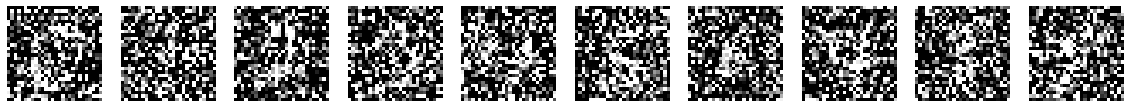

In [0]:
pl.figure(figsize=(20, 2))
for i in range(10):
    mask_i = (y_test == i).astype(float)
    index_i = np.random.choice(range(len(y_test)), 1, p=mask_i/np.sum(mask_i))
    ax = pl.subplot(1, 10, i+1)
    pl.imshow(x_test_noisy[index_i].reshape(28, 28))
    pl.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### Creating the autoencoder

In [0]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

l1 = Conv2D(16, (28, 28), padding='same', activation='relu', name='l1')(input_img)
l1_mp = MaxPooling2D((2, 2), name='l1_mp')(l1)

l2 = Conv2D(16, (14, 14), padding='same', activation='relu', name='l2')(l1_mp)
l2_mp = MaxPooling2D((2, 2), name='l2_mp')(l2)

l3 = Conv2D(16, (7, 7), padding='same', activation='relu', name='l3')(l2_mp)
l3_us = UpSampling2D((2, 2), name='l3_us')(l3)

l4 = Conv2D(16, (14, 14), padding='same', activation='relu', name='l4')(l3_us)
l4_us = UpSampling2D((2, 2), name='l4_us')(l4)

decoded = Conv2D(1, (28, 28), activation='sigmoid', padding='same')(l4_us)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
l1 (Conv2D)                  (None, 28, 28, 16)        12560     
_________________________________________________________________
l1_mp (MaxPooling2D)         (None, 14, 14, 16)        0         
_________________________________________________________________
l2 (Conv2D)                  (None, 14, 14, 16)        50192     
_________________________________________________________________
l2_mp (MaxPooling2D)         (None, 7, 7, 16)          0         
_________________________________________________________________
l3 (Conv2D)                  (None, 7, 7, 16)          12560     
_________________________________________________________________
l3_us (UpSampling2D)         (None, 14, 14, 16)        0         
__________

### Training the autoencoder

In [0]:
history = autoencoder.fit(x_train_noisy, x_train,
                          epochs=100,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 10s 161us/step - loss: 0.1481 - val_loss: 0.1529
Epoch 2/100
60000/60000 [==============================] - 9s 157us/step - loss: 0.1475 - val_loss: 0.1497
Epoch 3/100
60000/60000 [==============================] - 9s 156us/step - loss: 0.1468 - val_loss: 0.1548
Epoch 4/100
60000/60000 [==============================] - 9s 156us/step - loss: 0.1462 - val_loss: 0.1481
Epoch 5/100
60000/60000 [==============================] - 9s 157us/step - loss: 0.1457 - val_loss: 0.1481
Epoch 6/100
60000/60000 [==============================] - 9s 157us/step - loss: 0.1452 - val_loss: 0.1487
Epoch 7/100
60000/60000 [==============================] - 9s 157us/step - loss: 0.1448 - val_loss: 0.1484
Epoch 8/100
60000/60000 [==============================] - 9s 156us/step - loss: 0.1442 - val_loss: 0.1469
Epoch 9/100
60000/60000 [==============================] - 9s 157us/step - loss: 0.1439 - val

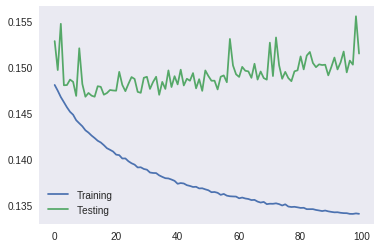

In [0]:
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Testing')
pl.legend()
pl.grid()

### Using the autoencoder to filter the noise in the images

In [0]:
# denoise the images
decoded_imgs = autoencoder.predict(x_test_noisy)

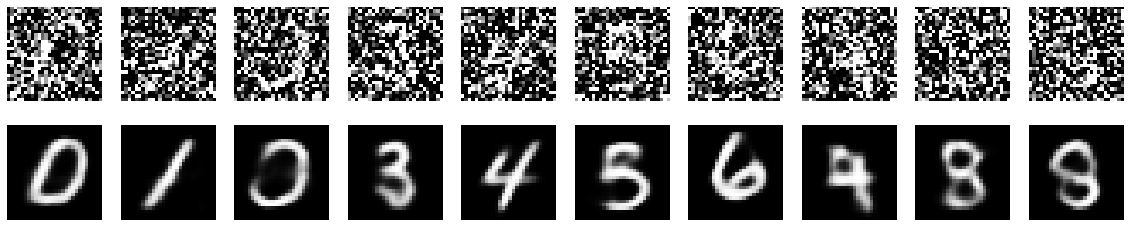

In [0]:
pl.figure(figsize=(20, 4))
for i in range(10):
    mask_i = (y_test == i).astype(float)
    index_i = np.random.choice(range(len(y_test)), 1, p=mask_i/np.sum(mask_i))
    
    ax = pl.subplot(2, 10, i+1)
    pl.imshow(x_test_noisy[index_i].reshape(28, 28))
    pl.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = pl.subplot(2, 10, 10+i+1)
    pl.imshow(decoded_imgs[index_i].reshape(28, 28))
    pl.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)